# EOF analysis of contributions to the IP
Here we represent an analysis of contributions to the ionospheric potential (IP), using the concept of empirical orthogonal functions (EOFs).

## Imports

In [5]:
# data processing
import numpy as np

# plotting the data
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, HPacker

# Fourier analysis
from scipy.fft import rfft, rfftfreq, irfft

## Loading the data

In [6]:
map_contrib = np.load('./data/DAILY-IP-MAP-V4.3.npy')
# original data with the shape (number of days, number of latitudes, number of longitudes)
# contains IP values (not normalised) depending on (d, lat, lon)
# d (axis 0) is the number of a day starting with 0 and ending with 4991
# every third day is taken, 0 corresponds to 1 Jan 1980 and 4991 corresponds to 29 Dec 2020
# lat (axis 1) describes the latitude (an integer in [0, 180])
# lon (axis 2) describes the longitude (an integer in [0, 360])

map_contrib /= np.mean(np.sum(map_contrib, axis=(1, 2)))
map_contrib *= 240e3
# normalisation of contributions to the IP to the global mean of 240 kV

ip = np.sum(map_contrib, axis=(1, 2))  # total IP values for different days

rmm = np.genfromtxt('./data/rmm.txt')
rmm = rmm[::3, [3, 4]]  # RMM1 and RMM2
# the array should look like the IP data (with every third day taken)
angle_rmm = np.arctan2(rmm[:, 1], rmm[:, 0])  # phase angles of RMM values
phase_rmm = np.floor((angle_rmm / np.pi + 1) * 4).astype(int)  # phase numbers

# phase separation
phase_avg_ip = np.zeros((8), dtype=float)
counter = np.zeros((8), dtype=int)

for i in range(len(phase_rmm)):
    counter[phase_rmm[i]] += 1
    phase_avg_ip[phase_rmm[i]] += ip[i]  # summing over each phase

phase_avg_ip /= counter  # averaging over each phase

## Preprocessing of the data for the EOF analysis

In [7]:
def remove_enso(a):
    """
    Remove the patterns related to ENSO variability.
    :param a: an array with the shape (number of days, number of longitudes)
    :return: the same array with ENSO variability removed
    """

    enso34 = np.load('./data/DAILY-ENSO34.npy')  # mean SST values in the Niño 3.4 region
    assert len(enso34) == a.shape[0]
    a_mean_before = np.mean(a, axis=0)  # mean values over days before the procedure

    p = np.polyfit(enso34, a, 1)
    a -= np.matmul(enso34[:, np.newaxis], p[0, np.newaxis, :]) + p[1, np.newaxis, :]
    # pointwise subtraction of a linear regression between enso34[:] and a[:, ...]

    a_mean_after = np.mean(a, axis=0)  # mean values over days after the procedure
    a += a_mean_before[np.newaxis, :] - a_mean_after[np.newaxis, :]
    # restoring the original mean values

    return a

def remove_seasonal(a):
    """
    Remove the seasonal variability.
    :param a: an array with the shape (number of days, number of longitudes)
    :return: the same array with first four harmonics of seasonal variability removed
    """

    frequencies = rfftfreq(a.shape[0], 3)  # every third day is taken in the data

    fourier_transform = rfft(a, axis=0)

    for m in range(1, 5):  # the removal of the four leading seasonal harmonics
        condition = (np.fabs(frequencies - m/365.25) <= frequencies[1]/2)
        # in fact frequencies[1] == 1 / (a.shape[0]*3)
        fourier_transform = np.where(
            condition[:, np.newaxis], 0, fourier_transform
        )

    a = irfft(fourier_transform, a.shape[0], axis=0)
    # the mean value changes negligibly since we remove seasonal harmonics with zero mean values

    return a

latitude = 15  # the boundary latitude for tropics

assert map_contrib.shape[1] == 180  # the next formula assumes this
assert latitude < 90  # the next formula will not work correctly for 90
map_contrib = np.sum(map_contrib[:, 90-latitude:-90+latitude, :], axis=1)
# summing over latitudes in the equatorial region

map_contrib = remove_enso(map_contrib)
map_contrib = remove_seasonal(map_contrib)
# this removes the variability on the ENSO timescale and seasonal variability
# it is necessary to do this in the presented order as the removal of patterns
# linearly related to the ENSO34 brings variability with a period of about one year

print(f'Processed contribution of the 15° S–15° N region: {np.sum(np.mean(map_contrib, axis=0))}')
map_contrib -= np.mean(map_contrib, axis=0)  # subtraction of the mean distribution

Processed contribution of the 15° S–15° N region: 207293.50170373698


## EOF analysis

In [8]:
def eof_analysis(a):
    """
    Calculate empirical orthogonal functions (EOFs) and related quantities.
    :param a: an array with the shape (number of days, number of longitudes)
    :return: EOFs, explained variances, principal components (PCs)
    """

    cov = np.cov(a, rowvar=False)  # covariance matrix
    lambdas, eofs = np.linalg.eig(cov)  # diagonalisation of the covariance matrix
    # EOFs are eigenvectors with the Euclidean norm equal to 1

    order = lambdas.argsort()[::-1]  # sorting by decreasing eigenvalues
    lambdas = lambdas[order]
    eofs = eofs[:, order]

    expvars = lambdas / np.sum(lambdas)  # the fraction of variance explained by each EOF

    pcs = np.matmul(a, eofs)  # PCs for the EOFs
    # a[day, longitude] × eofs[longitude, number] == pcs[day, number]

    return eofs, expvars, pcs

eofs, expvars, pcs = eof_analysis(map_contrib)

In [9]:
reofs = np.zeros((eofs.shape[0], 3), dtype=float)
reofs[:, 0] = eofs[:, 0]
reofs[:, 1] = (eofs[:, 1] - eofs[:, 2]) / np.sqrt(2)
reofs[:, 2] = (eofs[:, 1] + eofs[:, 2]) / np.sqrt(2)
# rotated EOFs

rpcs = np.zeros((pcs.shape[0], 3), dtype=float)
rpcs[:, 0] = pcs[:, 0]
rpcs[:, 1] = (pcs[:, 1] - pcs[:, 2]) / np.sqrt(2)
rpcs[:, 2] = (pcs[:, 1] + pcs[:, 2]) / np.sqrt(2)
# PCs corresponding to the rotated EOFs

rexpvars = np.zeros(3)
rexpvars[0] = expvars[0]
rexpvars[1] = (expvars[1] + expvars[2]) / 2
rexpvars[2] = (expvars[1] + expvars[2]) / 2
# the fraction of variance explained by each rotated EOF

In [10]:
# components of the longitudinal IP variation are obtained by
# multiplying EOFs by the respective PCs

# phase separation
phase_avg_comp = np.zeros((8, eofs.shape[0], eofs.shape[1]), dtype=float)
phase_avg_pc = np.zeros((8, pcs.shape[1]), dtype=float)
phase_avg_rcomp = np.zeros((8, eofs.shape[0], 3), dtype=float)
phase_avg_rpc = np.zeros((8, 3), dtype=float)
counter = np.zeros((8), dtype=int)

for i in range(len(phase_rmm)):
    counter[phase_rmm[i]] += 1
    phase_avg_comp[phase_rmm[i], :, :] += eofs[:, :] * pcs[i, np.newaxis, :]
    phase_avg_pc[phase_rmm[i], :] += pcs[i, :]
    phase_avg_rcomp[phase_rmm[i], :, :] += reofs[:, :] * rpcs[i, np.newaxis, :]
    phase_avg_rpc[phase_rmm[i], :] += rpcs[i, :]
    # summing over each phase

phase_avg_comp[:, :, :] /= counter[:, np.newaxis, np.newaxis]
phase_avg_pc[:, :] /= counter[:, np.newaxis]
phase_avg_rcomp[:, :, :] /= counter[:, np.newaxis, np.newaxis]
phase_avg_rpc[:, :] /= counter[:, np.newaxis]
# averaging over each phase
# the first resulting array contains components of longitudinal IP variation
# the indices are (MJO phase, longitude, EOF number)
# the second resulting array contains PCs of IP variation
# the indices are (MJO phase, EOF/PC number)
# the third and fourth arrays contain the same for the rotated EOFs

phase_avg_ip_comp = np.sum(phase_avg_comp, axis=1)
phase_avg_ip_rcomp = np.sum(phase_avg_rcomp, axis=1)
# summing over longitudes
# the first array contains total contributions to the IP from various EOFs
# the indices are (MJO phase, EOF number)
# the second array contains the same for the rotated EOFs

# Plots

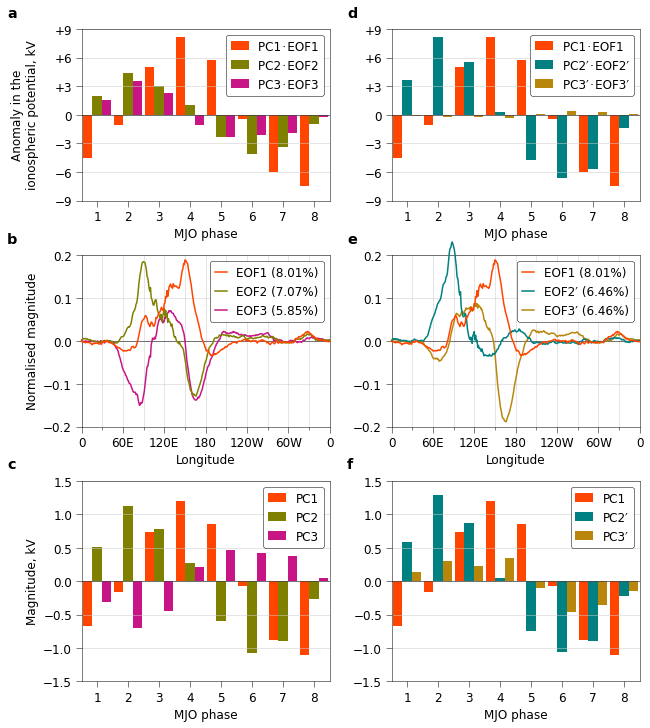

In [11]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10, 12),
                       constrained_layout=False, gridspec_kw={'height_ratios': [3, 3, 3.5]})

for i in range(3):
    for j in range(2):
        for axis in ['top', 'bottom', 'left', 'right']:
            ax[i, j].spines[axis].set_linewidth(0.5)
        ax[i, j].tick_params(length=6, width=0.5)
        ax[i, j].tick_params(length=3, width=0.5, which='minor')

for j in range(2):
    ax[1, j].set_xlim(0, 360)
    ax[1, j].set_xticks(np.arange(0, 361, 60))
    ax[1, j].set_xticks(np.arange(0, 361, 30), minor=True)
    ax[1, j].set_xticklabels(['0', '60E', '120E', '180',
                              '120W', '60W', '0'],
                             fontsize='large')
    ax[1, j].set_xlabel('Longitude', fontsize='large')

    ax[1, j].set_ylim(-0.2, 0.2)
    ax[1, j].set_yticks(np.arange(-0.2, 0.21, 0.1))
    ax[1, j].set_yticklabels([f'−{-y:.1f}' if y < 0
                              else f'{y:.1f}'
                              for y in np.arange(-0.2, 0.21, 0.1)],
                             fontsize='large')

    ax[1, j].grid(color='0.8', linewidth=0.5, which='both')
    ax[1, j].axhline(color='0.', linewidth=0.5)

    for i in [0, 2]:
        ax[i, j].set_xlim(0.5, 8.5)
        ax[i, j].set_xticks(np.arange(1, 9))
        ax[i, j].set_xticklabels(np.arange(1, 9).astype(int),
                                 fontsize='large')
        ax[i, j].set_xlabel('MJO phase', fontsize='large')

    ax[0, j].set_ylim(-9, 9)
    ax[0, j].set_yticks(np.arange(-9, 10, 3))
    ax[0, j].set_yticklabels([f'−{-y:d}' if y < 0
                              else f'+{y:d}' if y > 0
                              else f'{y:d}'
                              for y in np.arange(-9, 10, 3)],
                             fontsize='large')

    ax[2, j].set_ylim(-1.5, 1.5)
    ax[2, j].set_yticks(np.arange(-1.5, 1.6, 0.5))
    ax[2, j].set_yticklabels([f'−{-y:.1f}' if y < 0
                              else f'{y:.1f}'
                              for y in np.arange(-1.5, 1.6, 0.5)],
                             fontsize='large')

    for i in [0, 2]:
        ax[i, j].grid(color='0.8', linewidth=0.5, axis='y')
        ax[i, j].axhline(color='0.', linewidth=0.5)

ax[0, 0].set_ylabel('Anomaly in the\nionospheric potential, kV',
                    fontsize='large')
ax[1, 0].set_ylabel('Normalised magnitude', fontsize='large')
ax[2, 0].set_ylabel('Magnitude, kV', fontsize='large')

fig.align_ylabels([ax[0, 0], ax[1, 0], ax[2, 0]])

ax[0, 0].bar(np.arange(1, 9) - 0.3, phase_avg_ip_comp[:, 0] / 1e3,
             width=0.3, color='orangered', label='PC1 · EOF1')
ax[0, 0].bar(np.arange(1, 9), phase_avg_ip_comp[:, 1] / 1e3,
             width=0.3, color='olive', label='PC2 · EOF2')
ax[0, 0].bar(np.arange(1, 9) + 0.3, phase_avg_ip_comp[:, 2] / 1e3,
             width=0.3, color='mediumvioletred', label='PC3 · EOF3')
# hair spaces around '·'

ax[1, 0].plot(np.arange(0, 361), np.append(eofs[:, 0], eofs[0, 0]),
              linewidth=1.5, color='orangered', clip_on=False,
              zorder = 6, label=f'EOF1 ({expvars[0]:.2%})')
ax[1, 0].plot(np.arange(0, 361), np.append(eofs[:, 1], eofs[0, 1]),
              linewidth=1.5, color='olive', clip_on=False,
              zorder = 5, label=f'EOF2 ({expvars[1]:.2%})')
ax[1, 0].plot(np.arange(0, 361), np.append(eofs[:, 2], eofs[0, 2]),
              linewidth=1.5, color='mediumvioletred', clip_on=False,
              zorder = 4, label=f'EOF3 ({expvars[2]:.2%})')

ax[2, 0].bar(np.arange(1, 9) - 0.3, phase_avg_pc[:, 0] / 1e3,
             width=0.3, color='orangered', label='PC1')
ax[2, 0].bar(np.arange(1, 9), phase_avg_pc[:, 1] / 1e3,
             width=0.3, color='olive', label='PC2')
ax[2, 0].bar(np.arange(1, 9) + 0.3, phase_avg_pc[:, 2] / 1e3,
             width=0.3, color='mediumvioletred', label='PC3')

ax[0, 1].bar(np.arange(1, 9) - 0.3, phase_avg_ip_rcomp[:, 0] / 1e3,
             width=0.3, color='orangered', label='PC1 · EOF1')
ax[0, 1].bar(np.arange(1, 9), phase_avg_ip_rcomp[:, 1] / 1e3,
             width=0.3, color='teal', label='PC2′ · EOF2′')
ax[0, 1].bar(np.arange(1, 9) + 0.3, phase_avg_ip_rcomp[:, 2] / 1e3,
             width=0.3, color='darkgoldenrod', label='PC3′ · EOF3′')
# hair spaces around '·'

ax[1, 1].plot(np.arange(0, 361), np.append(reofs[:, 0], reofs[0, 0]),
              linewidth=1.5, color='orangered', clip_on=False,
              zorder = 6, label=f'EOF1 ({rexpvars[0]:.2%})')
ax[1, 1].plot(np.arange(0, 361), np.append(reofs[:, 1], reofs[0, 1]),
              linewidth=1.5, color='teal', clip_on=False,
              zorder = 5, label=f'EOF2′ ({rexpvars[1]:.2%})')
ax[1, 1].plot(np.arange(0, 361), np.append(reofs[:, 2], reofs[0, 2]),
              linewidth=1.5, color='darkgoldenrod', clip_on=False,
              zorder = 4, label=f'EOF3′ ({rexpvars[2]:.2%})')

ax[2, 1].bar(np.arange(1, 9) - 0.3, phase_avg_rpc[:, 0] / 1e3,
             width=0.3, color='orangered', label='PC1')
ax[2, 1].bar(np.arange(1, 9), phase_avg_rpc[:, 1] / 1e3,
             width=0.3, color='teal', label='PC2′')
ax[2, 1].bar(np.arange(1, 9) + 0.3, phase_avg_rpc[:, 2] / 1e3,
             width=0.3, color='darkgoldenrod', label='PC3′')

for j in range(2):
    leg = ax[1, j].legend(fontsize='large', framealpha=1,
                          edgecolor='0.', handlelength=1.)
    leg.get_frame().set_linewidth(0.5)
    for i in [0, 2]:
        leg = ax[i, j].legend(fontsize='large', framealpha=1,
                              edgecolor='0.', handlelength=1.5)
        leg.get_frame().set_linewidth(0.5)

for i in range(3):
    ax[i, 0].text(-0.3, 1.05, chr(ord('a') + i), fontsize='x-large',
                  fontweight='semibold', ha='left', va='bottom',
                  transform=ax[i, 0].transAxes)
    ax[i, 1].text(-0.18, 1.05, chr(ord('a') + 3 + i), fontsize='x-large',
                  fontweight='semibold', ha='left', va='bottom',
                  transform=ax[i, 1].transAxes)

fig.subplots_adjust(hspace=0.3, wspace=0.25)

fig.savefig('figures/eofs_and_pcs.eps', bbox_inches='tight')
fig.savefig('figures/eofs_and_pcs.png', dpi=300, bbox_inches='tight')

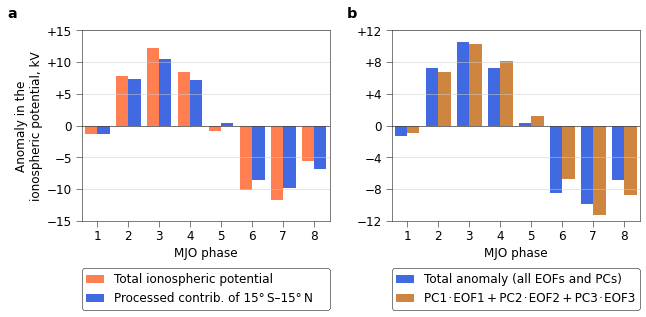

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 3.5),
                       constrained_layout=False)

for j in range(2):
    for axis in ['top', 'bottom', 'left', 'right']:
        ax[j].spines[axis].set_linewidth(0.5)
    ax[j].tick_params(length=6, width=0.5)

    ax[j].set_xlim(0.5, 8.5)
    ax[j].set_xticks(np.arange(1, 9))
    ax[j].set_xticklabels(np.arange(1, 9).astype(int),
                          fontsize='large')
    ax[j].set_xlabel('MJO phase', fontsize='large')

    ax[j].grid(color='0.8', linewidth=0.5, axis='y')
    ax[j].axhline(color='0.', linewidth=0.5)

ax[0].set_ylim(-15, 15)
ax[0].set_yticks(np.arange(-15, 16, 5))
ax[0].set_yticklabels([f'−{-y:d}' if y < 0
                       else f'+{y:d}' if y > 0
                       else f'{y:d}'
                       for y in np.arange(-15, 16, 5)],
                      fontsize='large')
ax[1].set_ylim(-12, 12)
ax[1].set_yticks(np.arange(-12, 13, 4))
ax[1].set_yticklabels([f'−{-y:d}' if y < 0
                       else f'+{y:d}' if y > 0
                       else f'{y:d}'
                       for y in np.arange(-12, 13, 4)],
                      fontsize='large')

ax[0].set_ylabel('Anomaly in the\nionospheric potential, kV',
                 fontsize='large')

ax[0].bar(np.arange(1, 9) - 0.2, phase_avg_ip / 1e3 - 240,
          width=0.4, color='coral',
          label='Total ionospheric potential')
ax[0].bar(np.arange(1, 9) + 0.2, np.sum(phase_avg_ip_comp, axis=1) / 1e3,
          width=0.4, color='royalblue',
          label='Processed contrib. of 15° S–15° N')
# thin spaces after '°'

ax[1].bar(np.arange(1, 9) - 0.2, np.sum(phase_avg_ip_comp, axis=1) / 1e3,
          width=0.4, color='royalblue',
          label='Total anomaly (all EOFs and PCs)')
ax[1].bar(np.arange(1, 9) + 0.2, np.sum(phase_avg_ip_comp[:, :3], axis=1) / 1e3,
          width=0.4, color='peru',
          label='PC1 · EOF1 + PC2 · EOF2 + PC3 · EOF3')
# hair spaces around '·', thin spaces around '+'

for j in range(2):
    leg = ax[j].legend(bbox_to_anchor=(0., -0.45, 1., 0.2),
                       loc='upper center', borderaxespad=0.,
                       mode = 'expand', fontsize='large',
                       framealpha=1, edgecolor='0.', handlelength=1.5)
    leg.get_frame().set_linewidth(0.5)

ax[0].text(-0.3, 1.05, 'a', fontsize='x-large',
           fontweight='semibold', ha='left', va='bottom',
           transform=ax[0].transAxes)
ax[1].text(-0.18, 1.05, 'b', fontsize='x-large',
           fontweight='semibold', ha='left', va='bottom',
           transform=ax[1].transAxes)

fig.subplots_adjust(wspace=0.25)

fig.savefig('figures/equatorial_variation.eps', bbox_inches='tight')
fig.savefig('figures/equatorial_variation.png', dpi=300, bbox_inches='tight')

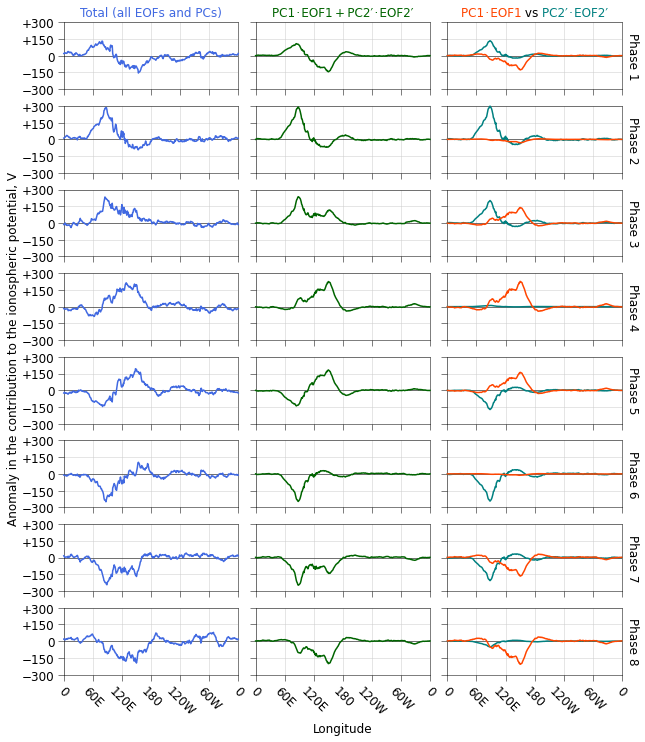

In [13]:
fig, ax = plt.subplots(nrows=8, ncols=3, figsize=(10, 12),
                       constrained_layout=False)

for i in range(8):
    for j in range(3):
        for axis in ['top', 'bottom', 'left', 'right']:
            ax[i, j].spines[axis].set_linewidth(0.5)
        ax[i, j].tick_params(length=6, width=0.5)
    
        ax[i, j].set_xlim(0, 360)
        ax[i, j].set_xticks(np.arange(0, 361, 60))

        if i == 7:
            ax[i, j].set_xticklabels(['0', '60E', '120E', '180',
                                      '120W', '60W', '0'],
                                     fontsize='large', rotation=315)
            if j == 1:
                ax[i, j].set_xlabel('Longitude', fontsize='large')
        else:
            ax[i, j].set_xticklabels([])

        ax[i, j].set_ylim(-300, 300)
        ax[i, j].set_yticks(np.arange(-300, 301, 150))

        if j == 0:
            ax[i, j].set_yticklabels([f'−{-y:d}' if y < 0
                                      else f'+{y:d}' if y > 0
                                      else f'{y:d}'
                                      for y in np.arange(-300, 301, 150)],
                                     fontsize='large')
            if i == 3:
                ax[i, j].yaxis.set_label_coords(-0.25, -0.125)
                ax[i, j].set_ylabel('Anomaly in the contribution to the '
                                    'ionospheric potential, V',
                                    fontsize='large', ha='center')
        else:
            ax[i, j].set_yticklabels([])
        
        ax[i, j].grid(color='0.8', linewidth=0.5)
        ax[i, j].axhline(color='0.', linewidth=0.5)

    ax[i, 2].yaxis.set_label_position('right')
    ax[i, 2].set_ylabel(f'Phase {i + 1}', fontsize='large',
                        rotation=270, va='bottom')

    ys = np.sum(phase_avg_comp[i, :, :], axis=1)
    ax[i, 0].plot(np.arange(0, 361), np.append(ys, ys[0]), linewidth=1.5,
                  color='royalblue', clip_on=False, zorder = 4)

    ys = np.sum(phase_avg_rcomp[i, :, :2], axis=1)
    ax[i, 1].plot(np.arange(0, 361), np.append(ys, ys[0]), linewidth=1.5,
                  color='darkgreen', clip_on=False, zorder = 4)

    ys = phase_avg_rcomp[i, :, 0]
    ax[i, 2].plot(np.arange(0, 361), np.append(ys, ys[0]), linewidth=1.5,
                  color='orangered', clip_on=False, zorder = 5)
    ys = phase_avg_rcomp[i, :, 1]
    ax[i, 2].plot(np.arange(0, 361), np.append(ys, ys[0]), linewidth=1.5,
                  color='teal', clip_on=False, zorder = 4)

box1 = TextArea('Total (all EOFs and PCs)',
                textprops=dict(color='royalblue', fontsize='large'))
box2 = TextArea('PC1 · EOF1 + PC2′ · EOF2′',
                textprops=dict(color='darkgreen', fontsize='large'))
box3 = TextArea('PC1 · EOF1',
                textprops=dict(color='orangered', fontsize='large'))
box4 = TextArea(' vs ',
                textprops=dict(color='0.', fontsize='large'))
box5 = TextArea('PC2′ · EOF2′',
                textprops=dict(color='teal', fontsize='large'))
box6 = HPacker(children=[box3, box4, box5], align='center',
               pad=0., sep=0.)
# hair spaces around '·', thin spaces around '+'
abox1 = AnchoredOffsetbox(loc='lower center', child=box1, pad=0.,
                          borderpad=0.3, frameon=False,
                          bbox_to_anchor=(0.5, 1.),
                          bbox_transform=ax[0, 0].transAxes)
abox2 = AnchoredOffsetbox(loc='lower center', child=box2, pad=0.,
                          borderpad=0.3, frameon=False,
                          bbox_to_anchor=(0.5, 1.),
                          bbox_transform=ax[0, 1].transAxes)
abox3 = AnchoredOffsetbox(loc='lower center', child=box6, pad=0.,
                          borderpad=0.3, frameon=False,
                          bbox_to_anchor=(0.5, 1.),
                          bbox_transform=ax[0, 2].transAxes)
ax[0, 0].add_artist(abox1)
ax[0, 1].add_artist(abox2)
ax[0, 2].add_artist(abox3)

fig.subplots_adjust(hspace=0.25, wspace=0.1)

fig.savefig('figures/longitudinal_structure.eps', bbox_inches='tight')
fig.savefig('figures/longitudinal_structure.png', dpi=300, bbox_inches='tight')